# Machine Learning Project 2024

## Background

The aim of this project is to explore the capabilities of pre-existing speech recognition/diarization models. While you may not be aware of them, these models are widespread in real life and play a crucial role in various applications. For example:

- **Content Creation and Streaming Platforms**:
  - Used extensively in live streaming, YouTube, Netflix, and other platforms to provide subtitles/captions, enhancing accessibility and viewer experience [[1]](https://support.google.com/youtube/answer/6373554?hl=en&utm_source=chatgpt.com).

- **Virtual Assistants**:
  - The likes of Siri/Alexa all use Automatic Speech Recognition (ASR)[[2]](https://medium.com/@zhouxiaogan0/how-do-voice-assistants-like-alexa-siri-actually-work-1885dce1f683).

- **Customer Service**:
  - While it can be frustrating, most customer service phone-lines use Automatic Speech Recognition, while you navigate their menu or provide your account identifiers [[3]](https://www.geeksforgeeks.org/what-is-speech-recognition/).

- **Legal and Business Environments**:
  - Facilitates the transcription of meetings and using Large Language Models can produce the minutes.[[4]](https://otter.ai/).

These models demonstrate how speech diarization has become an integral part of modern technology.

To begin with, we use a segment of the 2024 American Presidential debates.

In [26]:
# Packages used

import whisper
import os 
import csv
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
import openai
import requests
import assemblyai as aai
from pyannote.audio import Pipeline
import Authtoken
from collections import defaultdict
import numpy as np

## Part 1 - Speaker Diarisation

The first part of this project is to use pre-existing models to process an audio file and identify who was speaking and when.

There are many different models that perform speaker diarisation. Below are a few to look into;

- NVIDIA NeMo 2[5](https://github.com/NVIDIA/NeMo):
This is open-sourced software that is used to develop conversational AI models. It performs ASR, Text to Speech (TTS) and NAtural Language Processing (NLP) . According to the documentation it "requires a minimum of 1 NVIDIA GPU with at least 48GB memory for fine tuning, and 2 NVIDIA GPUs with at least 48GB memory each for pretraining", so it probably not suitable for this project.
- PyAnnote[[6]](https://docs.pyannote.ai/introduction):
This is also an open-sourced Spearker Diarisation model. It offers pre trained models. It should perform well for standard tasks but can struggle with larger datasets.
- Deepgram[[7]](https://developers.deepgram.com/docs/introduction):
Deepgram is a commercial product and as such has high accuracy. It's trained on massive datasets ensuring it works across many scenarios and languages. The subscription fees in this case mean it is not suitable for our purposes here.  
- WhisperX[[8]](https://github.com/m-bain/whisperX/blob/main/README.md):
WhisperX is an open source, speech recognition model created by OpenAI.


For this project we will initially look at WhisperX as its free of charge and can handle overlapping speakers/backround noise well. 



Whisper requires the command line tool ffmpeg to be installed on the system. This needs to be done via a package manager like chocolatey [[9]](https://chocolatey.org/) for windows. 

```
choco install ffmpeg
```

This installs software packages at a system level. Options for other OS are listed in the README file. 




In [2]:
# loading audio file to Whisper

file_path = "data/raw/TrumpHarrisDebate.mp3"

#select whisper model

model = whisper.load_model("base")
result = model.transcribe(file_path, verbose = False)

#show outputted text
print(result["text"])

c:\Users\kolea\anaconda3\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
c:\Users\k

Detected language: English


100%|██████████| 22381/22381 [00:32<00:00, 690.02frames/s]

 Thank you. Welcome to you both. It's wonderful to have you. It's an honor to have you both here tonight. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. This has been a disaster for people, for the middle class, but for every class. Donald Trump left us the worst unemployment since the Great Depression. And what we have done is clean up Donald Trump's mess. She's a Marxist. Everybody knows she's a Marxist. Her father is a Marxist professor in economics. And he taught her well. But her vice presidential pick says abortion in the ninth month is absolutely fine. He also says execution after birth. It's execution no longer abortion because the baby is born is okay. And that's not okay with me. One does not have to abandon their face or deeply held back. Or deeply held beliefs to agree. The government and Donald Trump certainly should not be telling a woman what to do with her body. Pregnant women who want to carry a pregnancy to te

In [3]:
# show full contents of result
result

{'text': " Thank you. Welcome to you both. It's wonderful to have you. It's an honor to have you both here tonight. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. This has been a disaster for people, for the middle class, but for every class. Donald Trump left us the worst unemployment since the Great Depression. And what we have done is clean up Donald Trump's mess. She's a Marxist. Everybody knows she's a Marxist. Her father is a Marxist professor in economics. And he taught her well. But her vice presidential pick says abortion in the ninth month is absolutely fine. He also says execution after birth. It's execution no longer abortion because the baby is born is okay. And that's not okay with me. One does not have to abandon their face or deeply held back. Or deeply held beliefs to agree. The government and Donald Trump certainly should not be telling a woman what to do with her body. Pregnant women who want to carry a pregn

Whisper has broken down the audiofile into segments, that begin and end as each person speaks. It gives an ID number for each segment, start and end times and also the text from that segment. It also identifies what language is being used. It does not however differentiate between who is speaking when.

In [4]:
#Show language
result['language']

'en'

In [5]:
# put the data for each segment into a dataframe for visualisation

#create dataframe
all_segments_df=[]

for seg in result['segments']:
  #not interested in tokens, temperature, seek, 
  for key in ['tokens', 'seek', 'temperature']:
        seg.pop(key, None)
  seg_df = pd.DataFrame.from_dict({0: seg}, orient='index')

  #append each segment to the dataframe
  all_segments_df.append(seg_df)

pd.concat(all_segments_df, axis=0)

,id,start,end,text,avg_logprob,compression_ratio,no_speech_prob
0,0,0.0,2.0,Thank you.,-0.198477,1.661355,0.277675
0,1,2.0,4.0,Welcome to you both.,-0.198477,1.661355,0.277675
0,2,4.0,5.0,It's wonderful to have you.,-0.198477,1.661355,0.277675
0,3,5.0,7.0,It's an honor to have you both here tonight.,-0.198477,1.661355,0.277675
0,4,7.0,11.0,We have inflation like very few people have e...,-0.198477,1.661355,0.277675
...,...,...,...,...,...,...,...
0,61,189.0,191.0,But we're not going back.,-0.071835,1.712500,0.055387
0,62,191.0,194.0,They've had three and a half years to create ...,-0.071835,1.712500,0.055387
0,63,194.0,196.0,And all the things we talked about.,-0.071835,1.712500,0.055387
0,64,196.0,198.0,Why hasn't she done it?,-0.071835,1.712500,0.055387


In the above output Whisper gives ``avg_logprob``,	``compression_ratio`` and	``no_speech_prob``.

- avg_logprob is the confidence level in the transcription. Higher values (closer to 0) mean more confident.
- compression_ratio is the ratio of lenght of the original audio to the transcribed text. High compression ratios can indicate, there are pauses, backround noice etc.
- no_speech_prob is the probability that the segment contains no speech.


In [6]:
# Save the transcribed text file

transcription = result["text"]

output_folder = "data/processed"
output_file = os.path.join(output_folder, "whisper_transcription.txt")
with open(output_file, "w") as file:
  file.write(transcription)

The above code has transcribed the full interview to a txt file. However it does not identify the different speakers or separate their words. To achieve this we need to use another model called pyannote.[[9]](https://github.com/pyannote/pyannote-audio/blob/develop/README.md)

In [7]:
#Access token to download pyannote models
from Authtoken import token


The below pyannote models take some time to download (12+minutes on my machine). To avoid this happening every time, I have directed it to be stored in the cache. Next time it runs it should pull it from there. 

In [8]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=token, cache_dir="./model.cache")
diarisation = pipeline(file_path)

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
c:\Users\kolea\anaconda3\Lib\inspect.py:992: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\kolea\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b\pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sp

Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cpu. Bad things might happen unless you revert torch to 1.x.


c:\Users\kolea\anaconda3\Lib\site-packages\speechbrain\utils\autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
c:\Users\kolea\anaconda3\Lib\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb

In [9]:
# show each time someone spoke and output it to a csv

output_file = os.path.join(output_folder, "speaking_times.csv")
with open(output_file, "w", newline="") as csvfile: 
  writer = csv.writer(csvfile)
  #headings
  writer.writerow(['Speaker', 'Start Time (s)', 'End Time (s)'])
  for turn, _, speaker in diarisation.itertracks(yield_label=True):
      writer.writerow([speaker, f"{turn.start:.1f}", f"{turn.end:.1f}"])
      print(f"{speaker}: {turn.start:.1f}s to {turn.end:.1f}s")

SPEAKER_02: 1.7s to 5.3s
SPEAKER_00: 1.8s to 2.5s
SPEAKER_00: 6.6s to 10.2s
SPEAKER_01: 10.3s to 20.6s
SPEAKER_02: 21.0s to 29.8s
SPEAKER_01: 30.1s to 52.6s
SPEAKER_02: 52.8s to 82.5s
SPEAKER_01: 82.5s to 97.0s
SPEAKER_00: 97.0s to 102.5s
SPEAKER_01: 100.4s to 100.7s
SPEAKER_02: 100.7s to 101.2s
SPEAKER_02: 103.4s to 105.2s
SPEAKER_00: 106.3s to 111.9s
SPEAKER_01: 108.4s to 115.6s
SPEAKER_00: 115.6s to 128.2s
SPEAKER_02: 128.3s to 159.9s
SPEAKER_01: 159.9s to 175.0s
SPEAKER_02: 175.0s to 187.8s
SPEAKER_02: 189.3s to 190.5s
SPEAKER_01: 190.8s to 203.7s


### Data presentation

In [10]:
#import the csv file as a Dataframe to visualise

speaker_csv = "data/processed/speaking_times.csv"

speaker_df = pd.read_csv(speaker_csv)
speaker_df

,Speaker,Start Time (s),End Time (s)
0,SPEAKER_02,1.7,5.3
1,SPEAKER_00,1.8,2.5
2,SPEAKER_00,6.6,10.2
3,SPEAKER_01,10.3,20.6
4,SPEAKER_02,21.0,29.8
5,SPEAKER_01,30.1,52.6
6,SPEAKER_02,52.8,82.5
7,SPEAKER_01,82.5,97.0
8,SPEAKER_00,97.0,102.5
9,SPEAKER_01,100.4,100.7


In [11]:
speaker_df["Duration"] = (speaker_df['End Time (s)']- speaker_df['Start Time (s)'])
speaker_df

,Speaker,Start Time (s),End Time (s),Duration
0,SPEAKER_02,1.7,5.3,3.6
1,SPEAKER_00,1.8,2.5,0.7
2,SPEAKER_00,6.6,10.2,3.6
3,SPEAKER_01,10.3,20.6,10.3
4,SPEAKER_02,21.0,29.8,8.8
5,SPEAKER_01,30.1,52.6,22.5
6,SPEAKER_02,52.8,82.5,29.7
7,SPEAKER_01,82.5,97.0,14.5
8,SPEAKER_00,97.0,102.5,5.5
9,SPEAKER_01,100.4,100.7,0.3


In [12]:
#create separate datafrmae for each speaker
#speaker_00
speaker_0_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_00"]

#speaker_01
speaker_1_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_01"]

#speaker_02
speaker_2_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_02"]

speaker_0_df

,Speaker,Start Time (s),End Time (s),Duration
1,SPEAKER_00,1.8,2.5,0.7
2,SPEAKER_00,6.6,10.2,3.6
8,SPEAKER_00,97.0,102.5,5.5
12,SPEAKER_00,106.3,111.9,5.6
14,SPEAKER_00,115.6,128.2,12.6


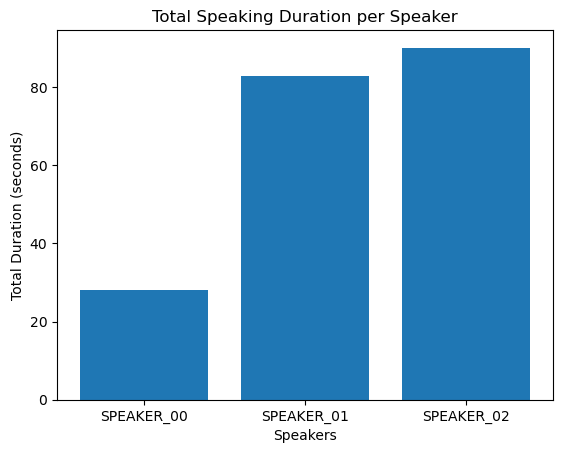

In [13]:
#Plot them on bar chart to visualise the difference.

total_durations = {
  "SPEAKER_00": speaker_0_df["Duration"].sum(),  
  "SPEAKER_01": speaker_1_df["Duration"].sum(),
  "SPEAKER_02": speaker_2_df["Duration"].sum(),
} 

labels = list(total_durations.keys())
values = list(total_durations.values())

#create plot
plt.bar(labels, values)

plt.xlabel("Speakers")
plt.ylabel("Total Duration (seconds)")
plt.title("Total Speaking Duration per Speaker")

#Show plot
plt.show()

Its clear to see from the above that Speaker_00 is the interviewer/moderator and Speaker_01 and Speaker_02 are the election candidates.

## Part 2 Speech to Text Analysis

As stated above Pyannote is useful for speaker diarisation but does not allow for transcribing the audio file, while whisper, transcribes but does not do speaker diarization. So we need to use a combination of the two. 

In order to transcribe the audio while retaining the speaker segmentation we need to split the audio file into individual segements. We can do this with the library pydub[[10]](https://audiosegment.readthedocs.io/en/latest/audiosegment.html). 

In [14]:
#load audio file
audio = AudioSegment.from_mp3(file_path)

#output folder
segment_folder = "data\processed\Segments"

#Loop through segments
speaker_segments = []
for turn, _, speaker in diarisation.itertracks(yield_label=True):
    #change start and end times to milliseconds
    segment = audio[turn.start *1000:turn.end *1000]

    #pass the output folder
    segment_file = os.path.join(segment_folder, f"{speaker}_{int(turn.start)}_{int(turn.end)}.mp3")    
    segment.export(segment_file, format="mp3")

    speaker_segments.append({"speaker": speaker, "start": turn.start, "end": turn.end, "file": segment_file})



The above code has split the audio into segments based on the speaker changing. The output files are in order of speaker so when we transcribe it below, they will need to be resorted in order of start time.

In [15]:
# Transcribe Segments

segment_transcriptions = []

#for loop to transcribe each segment
for segment in os.listdir(segment_folder):
  if segment.endswith(".mp3"):
        # Full path to the audio file
        segment_path = os.path.join(segment_folder, segment)
        
        # Transcribe the audio segment
        print(f"Transcribing: {segment_path}")
        segment_result = model.transcribe(segment_path)

        # Extract speaker, start, and end info from the filename
        file_parts = os.path.splitext(segment)[0].split("_")
        speaker = f"SPEAKER{file_parts[1]}"
        start = float(file_parts[2])
        end = float(file_parts[3])

        # Append the transcription result
        segment_transcriptions.append({
            "speaker": speaker,
            "start": start,
            "end": end,
            "text": segment_result["text"]
        })

#sort by start time to retain order of conversation
segment_transcriptions = sorted(segment_transcriptions, key=lambda x: x['start'])

# Print the results
for transcription in segment_transcriptions:
  print(f"{transcription['speaker']} ({transcription['start']}-{transcription['end']}")



Transcribing: data\processed\Segments\SPEAKER_00_106_111.mp3


c:\Users\kolea\anaconda3\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribing: data\processed\Segments\SPEAKER_00_115_128.mp3
Transcribing: data\processed\Segments\SPEAKER_00_1_2.mp3
Transcribing: data\processed\Segments\SPEAKER_00_6_10.mp3
Transcribing: data\processed\Segments\SPEAKER_00_97_102.mp3
Transcribing: data\processed\Segments\SPEAKER_01_100_100.mp3
Transcribing: data\processed\Segments\SPEAKER_01_108_115.mp3
Transcribing: data\processed\Segments\SPEAKER_01_10_20.mp3
Transcribing: data\processed\Segments\SPEAKER_01_159_174.mp3
Transcribing: data\processed\Segments\SPEAKER_01_190_203.mp3
Transcribing: data\processed\Segments\SPEAKER_01_30_52.mp3
Transcribing: data\processed\Segments\SPEAKER_01_82_97.mp3
Transcribing: data\processed\Segments\SPEAKER_02_100_101.mp3
Transcribing: data\processed\Segments\SPEAKER_02_103_105.mp3
Transcribing: data\processed\Segments\SPEAKER_02_128_159.mp3
Transcribing: data\processed\Segments\SPEAKER_02_174_187.mp3
Transcribing: data\processed\Segments\SPEAKER_02_189_190.mp3
Transcribing: data\processed\Segments\

In [16]:
#Create transcribed file
full_transcription_file = "data/processed/full_transcription.txt"

In [17]:
#Combine transcribed files
full_transcription_file = "data/processed/full_transcription.txt"
with open(full_transcription_file, "w") as file:
  for t in segment_transcriptions:
    file.write(f"Speaker {t['speaker']} ({t['start']:.1f}s - {t['end']:.1f}s): {t['text']}\n")

print("Created full transcription text file!")

Created full transcription text file!


The above cells have taken a 3 mins 43 second long audio file and broken it down to 20 individual audio segments retaining the time they start and finish speaking. They have then been transcribed individually and pasted back together to from one text file.

## Part 3: Large Language Models

There are a number of LLMs out there (the best known being ChatGPT), that are trained on vast amounts of data to understand and generate human-like language. It can generate new text based on context allowing it to answer questions and create its own content. 

If we pass the transcription that we have been able to produce to an LLM we can ask it questions about it. 

Hugging Face have a transformer libary of pre-trained sentinment analysis models. Some are designed for social media, other for multilingual. In our case the default model of ``distilbert-base-uncased-finetuned-sst-2-english`` is sufficient.

In [18]:
#hugging face have a transformer with a sentiment analysis

from transformers import pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

c:\Users\kolea\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [19]:
#open transcript as read only form
with open(full_transcription_file, "r") as file:
  transcript= file.read()

The max tokens to be uploaded to teh sentiment analyzer is 512 so we need to split the transcript into chunks.

In [20]:
# Split the transcript by lines (each line corresponds to a speaker's contribution)
lines = transcript.split("\n")

# Analyze each speaker's sentiment
for line in lines:
    # Skip empty lines
    if line.strip():
        print(f"Line: {line}")
        result = sentiment_analyzer(line)
        print(f"Sentiment: {result}")

Line: Speaker SPEAKER00 (1.0s - 2.0s):  Kamala Harris.
Sentiment: [{'label': 'NEGATIVE', 'score': 0.8671300411224365}]
Line: Speaker SPEAKER02 (1.0s - 5.0s):  Kamala Harris. It's up good to be here. She's a fun. Thank you.
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998607635498047}]
Line: Speaker SPEAKER00 (6.0s - 10.0s):  Welcome to you both. It's wonderful to have you. It's an honor to have you both here tonight.
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998480081558228}]
Line: Speaker SPEAKER01 (10.0s - 20.0s):  We have inflation like very few people have ever seen before, probably the worst in our nation's history. This has been a disaster for people, for the middle class, but for every class.
Sentiment: [{'label': 'NEGATIVE', 'score': 0.9996551275253296}]
Line: Speaker SPEAKER02 (20.0s - 29.0s):  Donald Trump left us the worst unemployment since the Great Depression. And what we have done is clean up Donald Trump's mess.
Sentiment: [{'label': 'NEGATIVE', 'score': 0.99888879

The Hugging Face transformer library [[11]](https://huggingface.co/blog/sentiment-analysis-python) uses a pre-trained model to tag data according to its sentiment, which can be either Positive, Negative or Neutral. 

It splits into smaller components called tokens. The tokens are then processed through a stack of transformer layers, which capture relationships between words and their contextual meaning. The output from the transformer then is fed into a classification head that maps it to a number of output classes (Positive, Negative or Neutral). The model also provides a confidence score for the predicted class. 



In [24]:

# Create a dictionary to store sentiment counts for each speaker
sentiment_counts = defaultdict(lambda: {"POSITIVE": 0, "NEGATIVE": 0, "NEUTRAL": 0})

# Analyze each speaker's sentiment
for line in lines:
    # Skip empty lines
    if line.strip():
        # Extract speaker and sentiment
        speaker = line.split(" ")[1]  #  speaker ID is the second word (e.g., SPEAKER00)
        sentiment_result = sentiment_analyzer(line) 
        sentiment_label = sentiment_result[0]['label']  # Extract the sentiment label

        # Increment the count for the corresponding sentiment
        sentiment_counts[speaker][sentiment_label] += 1

sentiment_results = dict(sentiment_counts)
sentiment_results

{'SPEAKER00': {'POSITIVE': 2, 'NEGATIVE': 3, 'NEUTRAL': 0},
 'SPEAKER02': {'POSITIVE': 2, 'NEGATIVE': 6, 'NEUTRAL': 0},
 'SPEAKER01': {'POSITIVE': 1, 'NEGATIVE': 6, 'NEUTRAL': 0}}

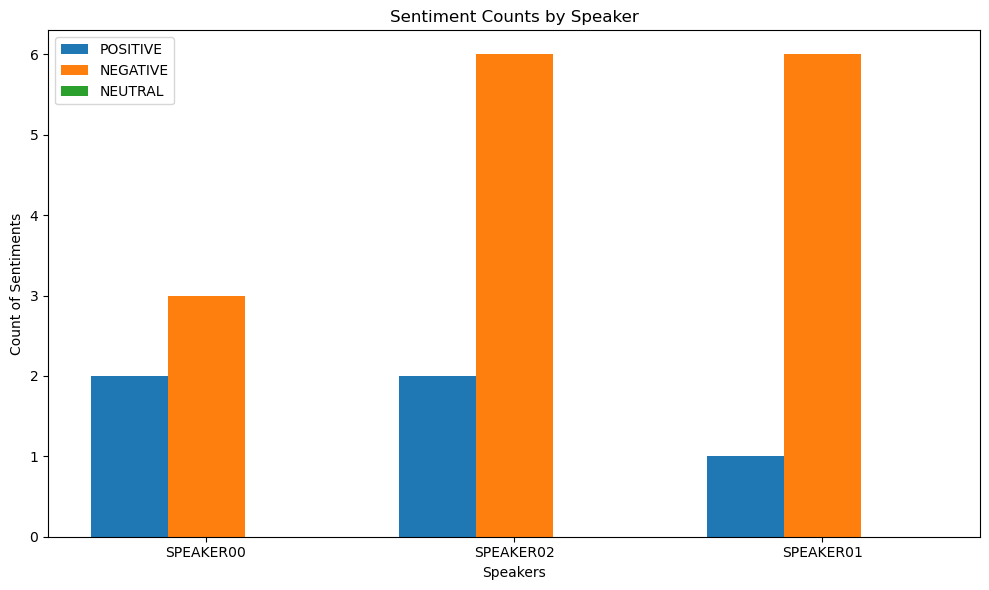

In [27]:
# Display the sentiment per speaker

# Prepare data for plotting
labels = list(sentiment_results.keys())  # Speakers
categories = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
data = {category: [sentiment_results[speaker][category] for speaker in labels] for category in categories}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bar

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each sentiment category
for i, category in enumerate(categories):
    ax.bar(x + i * width, data[category], width, label=category)

# Add labels, title, and legend
ax.set_xlabel('Speakers')
ax.set_ylabel('Count of Sentiments')
ax.set_title('Sentiment Counts by Speaker')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

Looking at the above, seems to confirm Speaker00 as the moderator as they are more balanced and both candidates are overly negative

However based on quick eye ball test, we might not be able to take these results as confirmed. Instead we might need to find a better model. For example it classifies the following line as Positive;

"In Springfield, they're eating the dogs, the people that came in, they're eating the cats, they're eating the pets of the people that live there. And this is what's happening in our country."

Hugging Face also allows you to ask queries to a QA model like roBERTa. [[12]](https://huggingface.co/deepset/roberta-base-squad2)
 
The model combines the question and context into a single input sequence. It then uses its transformer layers to analyze relationships between the question and the context. The output highlights which part of the context best answers the question.

In [28]:
# Load a QA pipeline with a Hugging Face model
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")


In [30]:
question = "How many speakers are there?"

response = qa_pipeline(context=transcript, question=question)
print(response['answer'])

Kamala Harris


We can see from the above answer that while it is taking some information from the transcript it is not answering our question correctly. Perhaps it requires further training on our dataset before being implemented. 

There are models such as ChatGPT and Assembly AI which do all of this. They have automated speech recognition, speaker diarisation and LLM's that can analyse the text. However they both premium services that require a fee. In order to explore this functionality, I created an account with Assembly Ai.

Assembly AI is accessible through their API [[13]](https://www.assemblyai.com/docs). The api key has been set as a variable ``assembly_ai_token`` in a file called Authtoken.py. This has been included in the gitignore file so it wont appear in this repository.

In [31]:
# https://www.assemblyai.com/docs/getting-started

from Authtoken import assembly_ai_token

# # AI assembly transcription

aai.settings.api_key = assembly_ai_token

transcriber = aai.Transcriber()
aai_transcript = transcriber.transcribe(file_path)

if aai_transcript.status == aai.TranscriptStatus.error:
    print(aai_transcript.error)
else:
    print(aai_transcript.text)


INFO:httpx:HTTP Request: POST https://api.assemblyai.com/v2/upload "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.assemblyai.com/v2/transcript "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/181a249f-f660-4596-b572-cf42ac5d9c27 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/181a249f-f660-4596-b572-cf42ac5d9c27 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/181a249f-f660-4596-b572-cf42ac5d9c27 "HTTP/1.1 200 OK"


Kamala Harris. Let's have a good debate. Have fun. Thank you. Welcome to you both. It's wonderful to have you. It's an honor to have you both here. Tonight we have inflation like very few people have ever seen before. Probably the worst in our nation's history. This has been a disaster for people, for the middle class, but for every class. Donald Trump left us the worst unemployment since the Great Depression. And what we have done is clean up Donald Trump's mess. She's a Marxist. Everybody knows she's a Marxist. Her father is a Marxist professor in economics and he taught her well. But her vice presidential pick says abortion in the ninth month is absolutely fine. He also says execution after birth, it's execution. No longer abortion because the baby is born is okay. And that's not okay with me. One does not have to abandon their faith or deeply held beliefs to agree. The government and Donald Trump certainly should not be telling a woman what to do with her body. Pregnant women who w

In [32]:
# Now Transcribe with different speakers identified

config = aai.TranscriptionConfig(speaker_labels=True)

transcriber = aai.Transcriber()
speaker_transcript = transcriber.transcribe(
  file_path,
  config=config
)

for utterance in speaker_transcript.utterances:
  print(f"Speaker {utterance.speaker}: {utterance.text}")

    # Save speaker labels and transcriptions to a text file
  with open("data/processed/aai_transcription.txt", "w", encoding="utf-8") as file:
      for utterance in speaker_transcript.utterances:
          start_time = utterance.start/1000 # convert from milliseconds to seconds
          end_time = utterance.end/1000
          line = (
             f"[{start_time:.2f} - {end_time:.2f}]"
             f"Speaker {utterance.speaker}: {utterance.text}\n"
          )
          print(line)  # Print to console
          file.write(line)  # Write to file

INFO:httpx:HTTP Request: POST https://api.assemblyai.com/v2/upload "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.assemblyai.com/v2/transcript "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/6cdae4c2-0208-4b77-aca7-3d7251d45e65 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/6cdae4c2-0208-4b77-aca7-3d7251d45e65 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/6cdae4c2-0208-4b77-aca7-3d7251d45e65 "HTTP/1.1 200 OK"


Speaker A: Kamala Harris. Let's have a good debate.
[1.84 - 4.02]Speaker A: Kamala Harris. Let's have a good debate.

[4.15 - 4.70]Speaker B: Have fun.

[4.77 - 5.54]Speaker A: Thank you.

[6.56 - 9.67]Speaker C: Welcome to you both. It's wonderful to have you. It's an honor to have you both here.

[9.70 - 20.66]Speaker B: Tonight we have inflation like very few people have ever seen before. Probably the worst in our nation's history. This has been a disaster for people, for the middle class, but for every class.

[20.83 - 29.75]Speaker A: Donald Trump left us the worst unemployment since the Great Depression. And what we have done is clean up Donald Trump's mess.

[29.94 - 52.72]Speaker B: She's a Marxist. Everybody knows she's a Marxist. Her father is a Marxist professor in economics and he taught her well. But her vice presidential pick says abortion in the ninth month is absolutely fine. He also says execution after birth, it's execution. No longer abortion because the baby is born

In [33]:
#Interrogate using AssmeblyAI

prompt1 = "Can you tell me how many speakers there are and who they are?"

result = speaker_transcript.lemur.task(
  prompt1, final_model=aai.LemurModel.claude3_5_sonnet
)

print(result.response)

INFO:httpx:HTTP Request: POST https://api.assemblyai.com/lemur/v3/generate/task "HTTP/1.1 200 OK"


Based on the transcript, there appear to be at least 3 distinct speakers:

1. Kamala Harris - Identified as "Vice President Harris" in the transcript
2. Donald Trump - Referred to as "Donald Trump" and speaks in first person about his presidency
3. A moderator/interviewer - Not explicitly named, but asks questions and directs the conversation

It's difficult to be certain if there are additional speakers, as the transcript doesn't consistently attribute quotes to specific individuals. Some statements could potentially be from other participants or candidates. However, the main speakers that can be clearly identified are Kamala Harris and Donald Trump, with an unnamed moderator facilitating the debate or interview.


In [34]:
#Interrogate using AssmeblyAI

prompt2 = "Only based on the text and no pre-existing knowledge, can you tell if any speaker appears either conservative or liberal?"

result = speaker_transcript.lemur.task(
  prompt2, final_model=aai.LemurModel.claude3_5_sonnet
)

print(result.response)

INFO:httpx:HTTP Request: POST https://api.assemblyai.com/lemur/v3/generate/task "HTTP/1.1 200 OK"


Based solely on the text provided, without any pre-existing knowledge, there appear to be at least two speakers with contrasting views that could be characterized as conservative and liberal:

1. One speaker seems more conservative, making statements like:
- Calling the other speaker a "Marxist"
- Criticizing abortion policies
- Mentioning concerns about crime and immigration (the Springfield reference)
- Defending Donald Trump and criticizing the current administration

2. Another speaker seems more liberal, making statements like:
- Defending abortion rights and women's bodily autonomy
- Criticizing Donald Trump's presidency
- Emphasizing their election victory with "81 million people"
- Focusing on moving forward rather than looking to the past

The text presents these contrasting viewpoints in a debate-like format, suggesting opposing political ideologies are being represented, though the specific terms "conservative" and "liberal" are not used explicitly.


You can see from the output above the level of analysis is significantly more in depth than the free alternatives used previously

### Different Audio file

To fully explore the functions of AssemblyAi we will do the same as above on a new audio file. 

I wanted something a bit more challenging than the example debate. The audio file I chose is an mp3 of the tv show Father Ted[[14]](https://www.youtube.com/watch?v=Lflc3Sf4rlI). The show has music/background noise and a laugh track. On top of this the accents are all Irish and perhaps something the model has not heard before. 

In [37]:
father_ted_path = "data/raw/FatherTedSnippet.mp3"

aai.settings.api_key = assembly_ai_token

transcriber = aai.Transcriber()
aai_transcript = transcriber.transcribe(father_ted_path)

if aai_transcript.status == aai.TranscriptStatus.error:
    print(aai_transcript.error)
else:
    print(aai_transcript.text)

INFO:httpx:HTTP Request: POST https://api.assemblyai.com/v2/upload "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.assemblyai.com/v2/transcript "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/48e59a5c-f162-4bcb-b370-ccd7d48ab5c2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/48e59a5c-f162-4bcb-b370-ccd7d48ab5c2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/48e59a5c-f162-4bcb-b370-ccd7d48ab5c2 "HTTP/1.1 200 OK"


I'm sorry, I was looking for Mrs. Doyle. It is Mrs. Doyle. What? I thought you were Marilyn Monroe now? Couple of nice pints for you. Oh, great. We're a bit low, actually. There's plenty more where that came from. I tell you, I shouldn't be here at all. The police are after me. They're not. Yes. I'm so gorgeous, they want to put me under arrest. Actually, I'm a bit sad at the moment, Mrs. Doyle. Yes? I have to go to a funeral. Oh, no. Really? Yes. My last girlfriend, she died from exhaustion. Hello. Hello, Father. This is Pat Mustard, the new milkman. Oh, yeah. Just here over the south side of the island. Thought I'd spread myself around a bit. Mrs. Doyle, you need to do some dusting up in Father Jack's room. And there's a huge cobweb in the shed needs removing. All right. Also, Father. Well, I'll be on my way, Padre. Off on my rounds. Right, Ted. Looks like an ordinary blackboard, doesn't it? Yes, that's what I thought. But watch this. You see, you can rub off the letters. You can do 

In [38]:
# Now Transcribe with different speakers identified

config = aai.TranscriptionConfig(speaker_labels=True)

transcriber = aai.Transcriber()
speaker_transcript = transcriber.transcribe(
  father_ted_path,
  config=config
)

for utterance in speaker_transcript.utterances:
  print(f"Speaker {utterance.speaker}: {utterance.text}")

    # Save speaker labels and transcriptions to a text file
  with open("data/processed/father_ted_transcription.txt", "w", encoding="utf-8") as file:
      for utterance in speaker_transcript.utterances:
          start_time = utterance.start/1000 # convert from milliseconds to seconds
          end_time = utterance.end/1000
          line = (
             f"[{start_time:.2f} - {end_time:.2f}]"
             f"Speaker {utterance.speaker}: {utterance.text}\n"
          )
          print(line)  # Print to console
          file.write(line)  # Write to file

INFO:httpx:HTTP Request: POST https://api.assemblyai.com/v2/upload "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.assemblyai.com/v2/transcript "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/d8314dcd-67ad-45e1-8d8f-626f34071f14 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/d8314dcd-67ad-45e1-8d8f-626f34071f14 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/d8314dcd-67ad-45e1-8d8f-626f34071f14 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.assemblyai.com/v2/transcript/d8314dcd-67ad-45e1-8d8f-626f34071f14 "HTTP/1.1 200 OK"


Speaker A: I'm sorry, I was looking for Mrs. Doyle.
[29.59 - 33.33]Speaker A: I'm sorry, I was looking for Mrs. Doyle.

[33.67 - 35.65]Speaker B: It is Mrs. Doyle.

[36.39 - 47.33]Speaker A: What? I thought you were Marilyn Monroe now? Couple of nice pints for you.

[47.40 - 50.09]Speaker B: Oh, great. We're a bit low, actually.

[55.91 - 65.40]Speaker A: There's plenty more where that came from. I tell you, I shouldn't be here at all. The police are after me.

[65.51 - 66.39]Speaker B: They're not.

[66.48 - 78.20]Speaker A: Yes. I'm so gorgeous, they want to put me under arrest. Actually, I'm a bit sad at the moment, Mrs. Doyle.

[78.35 - 78.67]Speaker C: Yes?

[78.70 - 79.90]Speaker A: I have to go to a funeral.

[79.99 - 81.75]Speaker B: Oh, no. Really?

[81.84 - 86.83]Speaker A: Yes. My last girlfriend, she died from exhaustion.

[94.03 - 94.81]Speaker D: Hello.

[96.91 - 101.85]Speaker B: Hello, Father. This is Pat Mustard, the new milkman.

[102.83 - 103.77]Speaker D: Oh, yeah.


From eyeballing the transcript, it seems to be remarkably accurate. Neither the background noise, laugh track nor the accents seemed to cause any difficulties with the transcription. The only mistake I could see, is it identified the below 5 lines as different speakers when actually they are from the same character. 

````
[277.99 - 280.81]Speaker A: No, you mean he's been.
[280.98 - 281.69]Speaker D: Who?
[281.86 - 284.37]Speaker C: I can't Ho, ho.
[285.03 - 286.73]Speaker D: He. No, wait. What?
[289.11 - 290.41]Speaker C: He's been what?
````

In [39]:
#Interrogate using AssmeblyAI

prompt3 = "Can you tell me what this clip is from?"

result = speaker_transcript.lemur.task(
  prompt3, final_model=aai.LemurModel.claude3_5_sonnet
)

print(result.response)

INFO:httpx:HTTP Request: POST https://api.assemblyai.com/lemur/v3/generate/task "HTTP/1.1 200 OK"


This clip appears to be a transcript from an episode of the British sitcom "Father Ted". The dialogue features characters like Father Ted, Dougal, Mrs. Doyle, and Pat Mustard, who are all recognizable characters from the show. The humor and situations described are typical of the series, including misunderstandings, exaggerated characters, and comedic scenarios set on the fictional Craggy Island. The transcript seems to focus on a storyline involving a new milkman named Pat Mustard and some suspicions about his activities on the island.


Using the above prompt we can see that the model was able to take the text and identify what show it was from, and who the characters are. 

In [40]:
#Interrogate using AssmeblyAI

prompt4 = "What are Pat Mustard's intentions?"

result = speaker_transcript.lemur.task(
  prompt4, final_model=aai.LemurModel.claude3_5_sonnet
)

print(result.response)

INFO:httpx:HTTP Request: POST https://api.assemblyai.com/lemur/v3/generate/task "HTTP/1.1 200 OK"


Based on the transcript, it appears that Pat Mustard, the new milkman, has questionable intentions:

1. He seems to be flirting with and possibly having affairs with women on his milk delivery route, including Mrs. Doyle.

2. There are implications that he may be the father of several "hairy babies" on Craggy Island, suggesting he's been "delivering more than dairy products."

3. He makes suggestive comments, like asking to put his "massive tool" in Mrs. Doyle's box (though this is apparently a misunderstanding about a literal tool).

4. He boasts about his various accomplishments and attributes, which seem exaggerated or false, possibly to impress women.

5. When confronted by Father Ted about the hairy babies, he responds evasively, saying he's "a very careful man," but also implies he doesn't use contraception.

Overall, Pat Mustard's intentions appear to be primarily sexual in nature, using his position as a milkman to pursue affairs with women on the island, potentially fathering 

From this answer it is clear that the model not only provides factual answers based on the text but can also pick up on the context of the text,  read between the lines and even infer humour. Overall it is much more impressive than the free models from hugging face that were tested.

## Conclusion

This project shows how machine learning and natural language processing can be used to break down and analyze audio from interviews and debates. By combining tools like speaker diarisation, speech-to-text transcription, and sentiment analysis with large language models, it creates a powerful way to pull useful insights out of complex audio recordings.

The tool makes it easier to see who spoke, how long they spoke, and even get a sense of their perspective or tone. This can be super handy for things like media analysis, understanding political debates, or digging into communication patterns. While it’s not perfect—background noise, overlapping voices, and tricky sentiment can still be tough—it’s a solid start and opens the door for future improvements.

Testing it on different types of audio really helped highlight both its strengths and where it could be better, like improving speaker accuracy and expanding what it can analyze. Overall, it’s a flexible and practical tool that could be a game-changer for journalism, social research, and more.

## References

1. https://support.google.com/youtube/answer/6373554?hl=en&utm_source=chatgpt.com
2. https://medium.com/@zhouxiaogan0/how-do-voice-assistants-like-alexa-siri-actually-work-1885dce1f683
3. https://www.geeksforgeeks.org/what-is-speech-recognition/
4. https://otter.ai/
5. https://github.com/NVIDIA/NeMo
6. https://docs.pyannote.ai/introduction
7. https://developers.deepgram.com/docs/introduction
8. https://github.com/m-bain/whisperX/blob/main/README.md
9. https://github.com/pyannote/pyannote-audio/blob/develop/README.md
10. https://audiosegment.readthedocs.io/en/latest/audiosegment.html
11. https://huggingface.co/blog/sentiment-analysis-python
12. https://huggingface.co/deepset/roberta-base-squad2
13. https://www.assemblyai.com/docs
14. https://www.youtube.com/watch?v=Lflc3Sf4rlI

## General Background Reading:

- https://www.assemblyai.com/blog/top-speaker-diarization-libraries-and-apis/
- https://konstantin-rink.medium.com/transcribe-audio-files-with-openais-whisper-e973ae348aa7
- https://www.youtube.com/watch?v=kCToqfFjGck
- https://github.com/pyannote/pyannote-audio/blob/develop/README.md
- https://audiosegment.readthedocs.io/en/latest/audiosegment.html
- https://community.openai.com/t/how-do-i-call-chatgpt-api-with-python-code/554554
- https://www.assemblyai.com/docs/getting-started
